In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc

# Key Metrics

In [3]:
# Winrate
winrate = 0.3

# Risk Reward
riskreward = 3.5

# Trade Frequency
frequency = 56718

In [4]:
# Expectancy
(winrate*riskreward - (1-winrate)*1)

0.3500000000000001

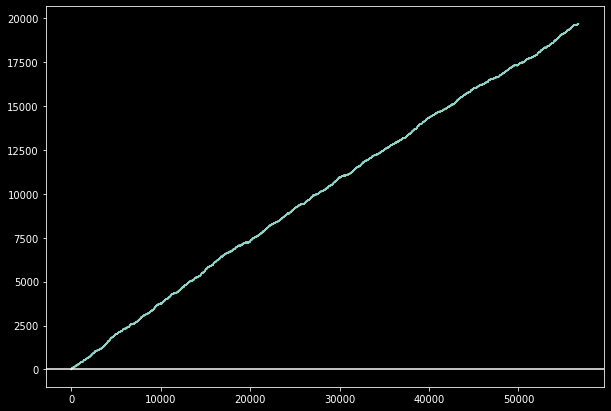

In [6]:
pnl = [0]

for i in range(frequency):
    
    trade = np.random.choice(['profit']*int(winrate*100) + ['loss']*int((1-winrate)*100))

    if trade == 'profit':
        pnl.append(riskreward)

    elif trade == 'loss':
        pnl.append(-1)

pnl = np.array(pnl)

plt.figure(figsize=(10, 7))
plt.style.use('dark_background')
plt.plot(pnl.cumsum())
plt.axhline(0)

____

# Let's Build A Strategy!!!

In [190]:
# Resampling Dictionary
ohlc_dict = {
'open':'first',
'high':'max',
'low':'min',
'close':'last',
'volume':'sum',
'time':'first',
'date':'first'
}

In [191]:
# Read Price Data from CSV
price_data_raw = pd.read_csv('Data/TATASTEEL_1m.csv')
price_data_raw = price_data_raw['date open high low close volume'.split()]
price_data_raw.columns = 'datetime open high low close volume'.split()
price_data_raw['datetime'] = price_data_raw['datetime'].apply(lambda x: x.split('+')[0])
price_data_raw['datetime'] = price_data_raw['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
price_data_raw['time'] = price_data_raw['datetime'].apply(lambda x: x.time())
price_data_raw['date'] = price_data_raw['datetime'].apply(lambda x: x.date())
price_data_raw.set_index('datetime', inplace=True)

# IDEATION

In [192]:
price_data = price_data_raw.loc['2015-01-01':'2016-01-01 00:00:00'].copy().dropna()

In [193]:
price_data = price_data.resample('5min', closed='left', label='left').apply(ohlc_dict).dropna()

### Use MA Crossover for direction
### Use RSI to overbought/oversold

In [194]:
price_data['ma1'] = price_data['close'].rolling(window=10).mean()
price_data['ma2'] = price_data['close'].rolling(window=30).mean()

[datetime.date(2015, 12, 10), datetime.date(2015, 12, 11), datetime.date(2015, 12, 14)]


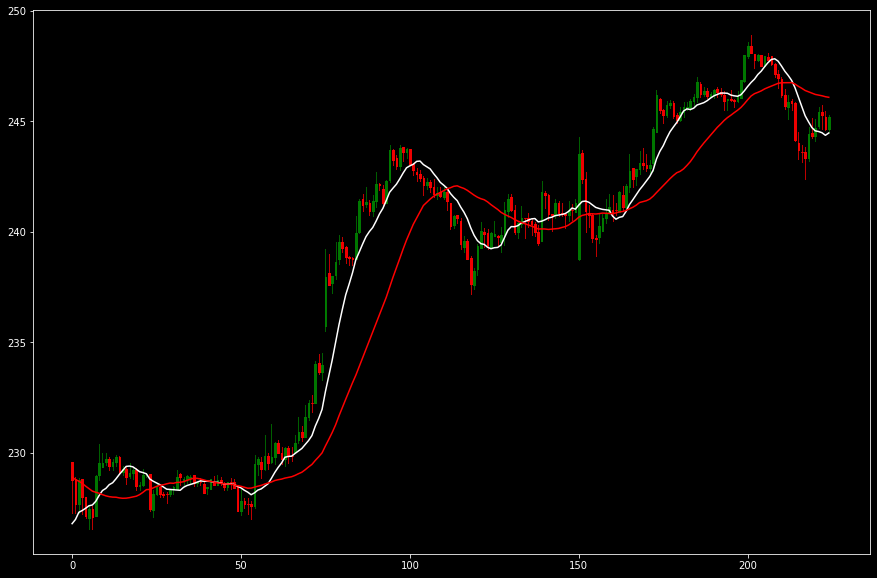

In [196]:
plt.style.use('dark_background')
plt.figure(figsize=(15, 10))
ax1 = plt.axes()

date_now = list(price_data['date'].drop_duplicates())[-15:-12]

print(date_now)

if type(date_now) == list:
    subset = price_data[price_data['date'].apply(lambda x: x in date_now)]
    
else: subset = price_data[price_data['date'] == date_now].copy()#.iloc[-100:]

candlestick2_ohlc(ax1, subset['open'], subset['high'], subset['low'], subset['close'], width = 0.5, colorup='g')
plt.plot(range(len(subset)), subset['ma1'], c='w')
plt.plot(range(len(subset)), subset['ma2'], c='r')
plt.show()

In [197]:
from pyti.relative_strength_index import relative_strength_index as calc_rsi

In [219]:
price_data['rsi'] = calc_rsi(price_data['close'], 2)

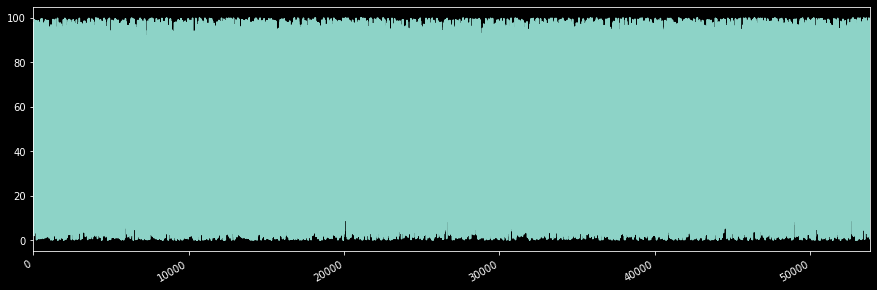

In [220]:
price_data['rsi'].plot(figsize=(15, 5), use_index=False)

# In Sample Design

### 2015 to 2017 is IN SAMPLE data.

### We will use this to build the strategy

In [201]:
price_data = price_data_raw.loc['2015-01-01':'2018-01-01 00:00:00'].copy().dropna()

In [202]:
price_data = price_data.resample('5min', closed='left', label='left').apply(ohlc_dict).dropna()

In [221]:
price_data['rsi'] = calc_rsi(price_data['close'], 2)
price_data['ma1'] = price_data['close'].rolling(window=10).mean()
price_data['ma2'] = price_data['close'].rolling(window=30).mean()

In [224]:
# Only MA Crossover
price_data['long'] = price_data[(price_data['ma1'].shift() > price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 2]['open']
price_data['short'] = price_data[(price_data['ma1'].shift() < price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 2]['open']

In [226]:
# MA + RSI
price_data['long'] = price_data[(price_data['rsi'].shift() < 95).apply(int) + (price_data['ma1'].shift() > price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 3]['open']
price_data['short'] = price_data[(price_data['rsi'].shift() > 5).apply(int) + (price_data['ma1'].shift() < price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 3]['open']

PnL:  148.1
MDD:  -72.7


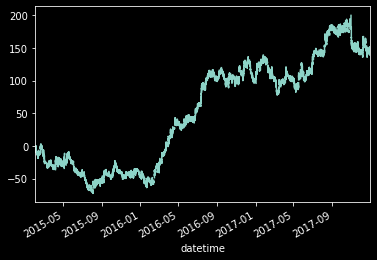

In [227]:
# LONG Trades
print('PnL: ', np.round((price_data['close'] - price_data['long']).sum(), 2))
print('MDD: ', np.round((price_data['close'] - price_data['long']).cumsum().min(), 2))
(price_data['close'] - price_data['long']).cumsum().plot()

PnL:  479.1
MDD:  -0.8


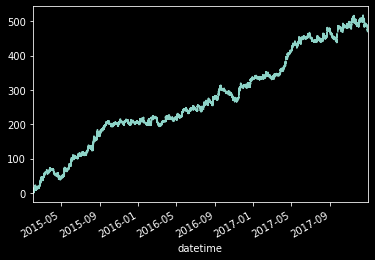

In [228]:
# SHORT Trades
print('PnL: ', np.round((price_data['short'] - price_data['close']).sum(), 2))
print('MDD: ', np.round((price_data['short'] - price_data['close']).cumsum().min(), 2))
(price_data['short'] - price_data['close']).cumsum().plot()

In [229]:
longs = (price_data['close'] - price_data['long'])/price_data['long']
shorts = (price_data['short'] - price_data['close'])/price_data['short']

In [230]:
trades = pd.concat([longs.fillna(0), shorts.fillna(0)], axis=1)

In [231]:
trades.columns = ['long', 'short']

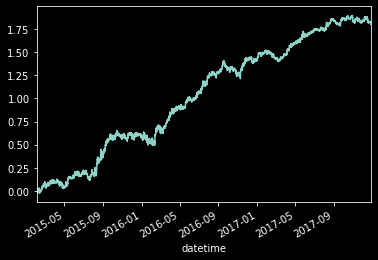

In [232]:
trades.sum(axis=1).cumsum().plot()

In [233]:
equity = trades.sum(axis=1)*100

equity_daily = equity.resample('D', closed='right', label='right').sum().replace(0, np.nan).dropna()
equity_weekly = equity.resample('W', closed='right', label='right').sum()
equity_monthly = equity.resample('M', closed='right', label='right').sum()
equity_quarterly = equity.resample('3M', closed='left', label='left').sum()
equity_annual = equity.resample('Y', closed='right', label='right').sum()

xs = equity.cumsum()
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period

report = pd.DataFrame(index = range(0, 1), 
 data={
 'Start Date': equity_daily.index[0].date(),
 'End Date': equity_daily.index[-1].date(),
 'Total Returns %': np.round((equity_monthly).sum(), 2),
 'Annualized Returns %': np.round(equity_annual.mean(), 2),
 'Annualized Volatility %' : np.round(equity_annual.std(), 2),
 'Maximum Drawdown %' : ((equity.cumsum()).round(2) - (equity.cumsum()).round(2).cummax()).min(),
 'Duration of MDD' : str(np.max([abs((j - i).days), abs((i - j).days)])) + ' Days',
 }).transpose()

report.columns = ['Value']

monthly_returns = pd.DataFrame(columns = range(1, 13))

monthly_copy = equity_monthly.copy()
monthly_copy = monthly_copy.reset_index()
monthly_copy['year'] = monthly_copy['datetime'].apply(lambda x: x.year)
monthly_copy['month'] = monthly_copy['datetime'].apply(lambda x: x.month)

years = list(monthly_copy['year'].drop_duplicates())

for year in years:
    monthly_returns.loc[len(monthly_returns)] = np.nan
    
    months = list(monthly_copy[monthly_copy['year'] == year]['month'])
    
    for month in months:
        
        copy = monthly_copy[monthly_copy['year'] == year].copy()
        pnl = np.round(copy[copy['month'] == month][0].values[0], 2)
        monthly_returns.iloc[-1][month] = pnl

monthly_returns.index = years
monthly_returns.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_returns['Total'] = monthly_returns.fillna(0).sum(axis=1)

def color(val):
    color = 'black'
    if val > 0:
        color = 'green'
    elif val < 0:
        color = 'red'
    return 'background-color: %s' % color

/home/blackrose/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


       --- Backtest Report ---


,Value
Start Date,2015-02-03
End Date,2017-12-30
Total Returns %,181.75
Annualized Returns %,60.58
Annualized Volatility %,21.46
Maximum Drawdown %,-19.3
Duration of MDD,51 Days


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
2015,nan,7.91,1.7,-5.46,10.31,7,-2.05,19.31,18.66,0.31,1.63,-1.26,58.06
2016,-5.38,10.29,17.4,9.23,11.38,5.93,16.2,4.76,3.99,-7.31,18.57,-1.86,83.2
2017,7.94,-6.01,3.99,13.08,7.8,5.84,1.17,9.49,2.59,-3.45,-0.28,-1.68,40.48


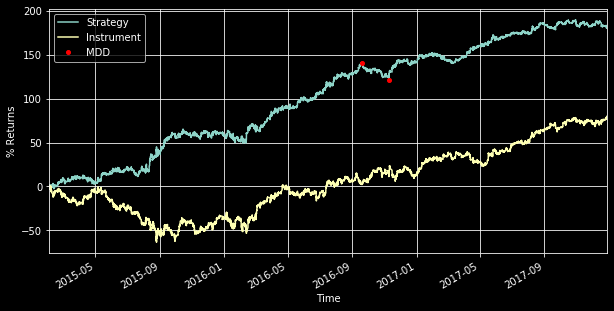

In [234]:
print('\033[1m       --- Backtest Report ---')
display(report)
print()
display(monthly_returns.style.applymap(color))
print()
(equity.cumsum()).plot(figsize=(10, 5))
(price_data['close'].pct_change().cumsum()*100).plot()
plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=4)
plt.xlabel('Time')
plt.ylabel('% Returns')
plt.grid()
plt.legend(['Strategy', 'Instrument', 'MDD'])

# Out Sample Test

In [235]:
price_data = price_data_raw.loc['2018-01-01':].copy().dropna()

In [236]:
price_data = price_data.resample('5min', closed='left', label='left').apply(ohlc_dict).dropna()

In [237]:
price_data['rsi'] = calc_rsi(price_data['close'], 2)
price_data['ma1'] = price_data['close'].rolling(window=10).mean()
price_data['ma2'] = price_data['close'].rolling(window=30).mean()

In [238]:
price_data['long'] = price_data[(price_data['rsi'].shift() < 95).apply(int) + (price_data['ma1'].shift() > price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 3]['open']
price_data['short'] = price_data[(price_data['rsi'].shift() > 5).apply(int) + (price_data['ma1'].shift() < price_data['ma2'].shift()).apply(int) + (price_data['time'] < datetime.time(15, 15)).apply(int) == 3]['open']

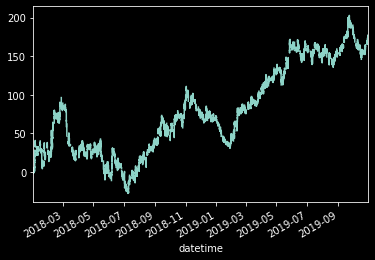

In [239]:
(price_data['close'] - price_data['long']).cumsum().plot()

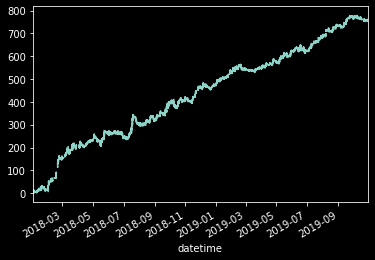

In [240]:
(price_data['short'] - price_data['close']).cumsum().plot()

In [241]:
longs = (price_data['close'] - price_data['long'])/price_data['long']
shorts = (price_data['short'] - price_data['close'])/price_data['short']

In [242]:
trades = pd.concat([longs.fillna(0), shorts.fillna(0)], axis=1)

In [243]:
trades.columns = ['long', 'short']

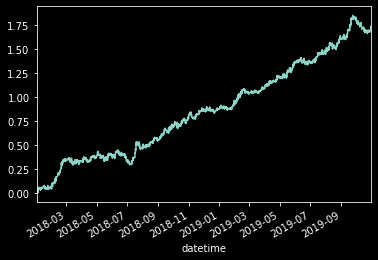

In [244]:
trades.sum(axis=1).cumsum().plot()

In [245]:
equity = trades.sum(axis=1)*100

equity_daily = equity.resample('D', closed='right', label='right').sum().replace(0, np.nan).dropna()
equity_weekly = equity.resample('W', closed='right', label='right').sum()
equity_monthly = equity.resample('M', closed='right', label='right').sum()
equity_quarterly = equity.resample('3M', closed='left', label='left').sum()
equity_annual = equity.resample('Y', closed='right', label='right').sum()

xs = equity.cumsum()
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period

report = pd.DataFrame(index = range(0, 1), 
 data={
 'Start Date': equity_daily.index[0].date(),
 'End Date': equity_daily.index[-1].date(),
 'Total Returns %': np.round((equity_monthly).sum(), 2),
 'Annualized Returns %': np.round(equity_annual.mean(), 2),
 'Annualized Volatility %' : np.round(equity_annual.std(), 2),
 'Maximum Drawdown %' : ((equity.cumsum()).round(2) - (equity.cumsum()).round(2).cummax()).min(),
 'Duration of MDD' : str(np.max([abs((j - i).days), abs((i - j).days)])) + ' Days',
 }).transpose()

report.columns = ['Value']

monthly_returns = pd.DataFrame(columns = range(1, 13))

monthly_copy = equity_monthly.copy()
monthly_copy = monthly_copy.reset_index()
monthly_copy['year'] = monthly_copy['datetime'].apply(lambda x: x.year)
monthly_copy['month'] = monthly_copy['datetime'].apply(lambda x: x.month)

years = list(monthly_copy['year'].drop_duplicates())

for year in years:
    monthly_returns.loc[len(monthly_returns)] = np.nan
    
    months = list(monthly_copy[monthly_copy['year'] == year]['month'])
    
    for month in months:
        
        copy = monthly_copy[monthly_copy['year'] == year].copy()
        pnl = np.round(copy[copy['month'] == month][0].values[0], 2)
        monthly_returns.iloc[-1][month] = pnl

monthly_returns.index = years
monthly_returns.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_returns['Total'] = monthly_returns.fillna(0).sum(axis=1)

def color(val):
    color = 'black'
    if val > 0:
        color = 'green'
    elif val < 0:
        color = 'red'
    return 'background-color: %s' % color

/home/blackrose/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


       --- Backtest Report ---


,Value
Start Date,2018-01-02
End Date,2019-10-31
Total Returns %,172.91
Annualized Returns %,86.45
Annualized Volatility %,2.51
Maximum Drawdown %,-18.87
Duration of MDD,29 Days


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
2018,7.81,25.99,-0.53,5.28,-0.23,-4.96,15.54,6.87,15.03,10.38,4.35,2.69,88.22
2019,8.07,8.13,4.97,10.77,16.58,0.2,10.84,13.44,20.45,-8.78,nan,nan,84.67


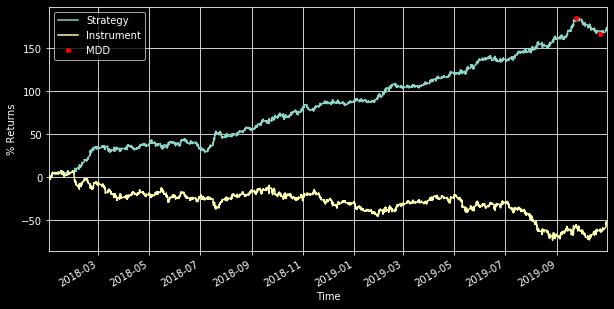

In [246]:
print('\033[1m       --- Backtest Report ---')
display(report)
print()
display(monthly_returns.style.applymap(color))
print()
(equity.cumsum()).plot(figsize=(10, 5))
(price_data['close'].pct_change().cumsum()*100).plot()
plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=4)
plt.xlabel('Time')
plt.ylabel('% Returns')
plt.grid()
plt.legend(['Strategy', 'Instrument', 'MDD'])